In [1]:
import findspark
findspark.init()
from pyspark import SparkContext
sc=SparkContext()
sc

<SparkContext master=yarn appName=pyspark-shell>

In [2]:
from pyspark.sql import SparkSession
spark=SparkSession.builder.getOrCreate()
spark

# Data Preprocessing

In [3]:
data2019 = spark.read.option("header", "true").csv("s3://open-data-noaa/cleaneddata/*.csv")

In [4]:
data2019.show()

+-----------+-------------------+--------+---------+---------+----+-------+-------+-----+-----+------+------+-----+-----+
|    station|               date|latitude|longitude|elevation|wind|    cig|    vis| temp|  dew|   slp|liquid|liqhr|month|
+-----------+-------------------+--------+---------+---------+----+-------+-------+-----+-----+------+------+-----+-----+
|72549094933|2019-01-01T00:56:00|   42.55|-94.18333|    352.3| 5.7|  335.0|14484.0| -5.6| -7.8|1020.2|   0.0|  1.0|    1|
|72549094933|2019-01-01T01:56:00|   42.55|-94.18333|    352.3| 5.7|  396.0|16093.0| -7.8|-10.0|1022.7|   0.0|  1.0|    1|
|72549094933|2019-01-01T02:56:00|   42.55|-94.18333|    352.3| 6.2|  457.0|16093.0| -9.4|-11.7|1023.5|   0.0|  1.0|    1|
|72549094933|2019-01-01T03:56:00|   42.55|-94.18333|    352.3| 5.7|  518.0|14484.0|-10.6|-12.8|1025.0|   0.0|  1.0|    1|
|72549094933|2019-01-01T04:56:00|   42.55|-94.18333|    352.3| 6.7|  579.0|14484.0|-11.7|-13.9|1026.8|   0.0|  1.0|    1|
|72549094933|2019-01-01T

In [5]:
data=data2019.groupBy("station").agg({'latitude':'avg', 'longitude':'avg','elevation':'avg', 'wind':'avg', 'cig':'avg', 'vis':'avg', 'temp':'avg', 'dew':'avg', 'slp':'avg', 'liquid':'avg'})

In [6]:
data.printSchema()

root
 |-- station: string (nullable = true)
 |-- avg(liquid): double (nullable = true)
 |-- avg(latitude): double (nullable = true)
 |-- avg(dew): double (nullable = true)
 |-- avg(vis): double (nullable = true)
 |-- avg(longitude): double (nullable = true)
 |-- avg(wind): double (nullable = true)
 |-- avg(elevation): double (nullable = true)
 |-- avg(temp): double (nullable = true)
 |-- avg(cig): double (nullable = true)
 |-- avg(slp): double (nullable = true)



In [7]:
from pyspark.sql import functions
data = data.select(*(functions.col(col).cast("float").alias(col) for col in data.columns))

In [8]:
data.printSchema()

root
 |-- station: float (nullable = true)
 |-- avg(liquid): float (nullable = true)
 |-- avg(latitude): float (nullable = true)
 |-- avg(dew): float (nullable = true)
 |-- avg(vis): float (nullable = true)
 |-- avg(longitude): float (nullable = true)
 |-- avg(wind): float (nullable = true)
 |-- avg(elevation): float (nullable = true)
 |-- avg(temp): float (nullable = true)
 |-- avg(cig): float (nullable = true)
 |-- avg(slp): float (nullable = true)



In [9]:
data = data.withColumnRenamed("avg(latitude)","latitude")
data = data.withColumnRenamed("avg(liquid)","liquid")
data = data.withColumnRenamed("avg(dew)","dew")
data = data.withColumnRenamed("avg(vis)","vis")
data = data.withColumnRenamed("avg(longitude)","longitude")
data = data.withColumnRenamed("avg(wind)","wind")
data = data.withColumnRenamed("avg(elevation)","elevation")
data = data.withColumnRenamed("avg(temp)","temp")
data = data.withColumnRenamed("avg(cig)","cig")
data = data.withColumnRenamed("avg(slp)","slp")

In [10]:
data=data.dropna()

In [11]:
data=data.drop('station')

In [12]:
data.printSchema()

root
 |-- liquid: float (nullable = true)
 |-- latitude: float (nullable = true)
 |-- dew: float (nullable = true)
 |-- vis: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- wind: float (nullable = true)
 |-- elevation: float (nullable = true)
 |-- temp: float (nullable = true)
 |-- cig: float (nullable = true)
 |-- slp: float (nullable = true)



In [13]:
data.count()

6707

In [14]:
data.describe().toPandas().transpose()

/home/hadoop/miniconda/lib/python3.7/site-packages/pyarrow/util.py:39: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead
  warnings.warn(msg, FutureWarning)


,0,1,2,3,4
summary,count,mean,stddev,min,max
liquid,6707,0.3797537762401148,1.2088738255717428,0.0,63.5
latitude,6707,32.65529795006569,25.304361762385163,-78.8,81.166664
dew,6707,8.864341877460046,9.95269309216712,-31.321428,27.9
vis,6707,16171.996371865149,10367.568175214885,0.0,71615.66
longitude,6707,14.618832663720896,85.28433171298619,-179.98334,179.75
wind,6707,3.047421344612985,1.7324453717422978,0.0,19.581396
elevation,6707,296.35709708285646,494.94474224801485,-999.9,4701.0
temp,6707,13.77539589372258,9.688231396767176,-25.013725,37.6
cig,6707,11613.875369421608,7284.168907227306,30.0,22000.0


# Model-Ridge\Lasso\Decision Tree\Gradient-boosted tree

In [18]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

/home/hadoop/miniconda/lib/python3.7/site-packages/pyarrow/util.py:39: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead
  warnings.warn(msg, FutureWarning)


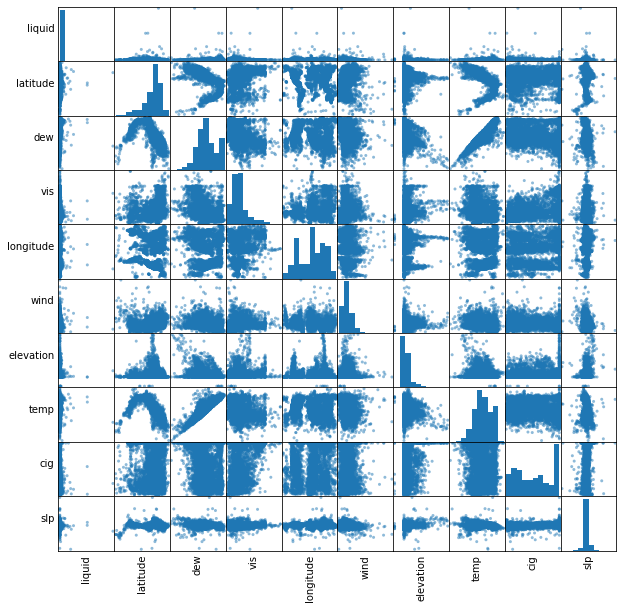

In [16]:
from pandas.plotting import scatter_matrix

numeric_features = [t[0] for t in data.dtypes if t[1] == 'float' ]
sampled_data = data.select(numeric_features).sample(False, 0.8).toPandas()
axs = scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [17]:
import six
for i in data.columns:
    if not( isinstance(data.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to temp for ", i, data.stat.corr('temp',i))

Correlation to temp for  liquid 0.13367557022544588
Correlation to temp for  latitude -0.601099321100245
Correlation to temp for  dew 0.9297631385954203
Correlation to temp for  vis -0.29245140605209236
Correlation to temp for  longitude 0.0969299860478152
Correlation to temp for  wind -0.2339219927905037
Correlation to temp for  elevation -0.174458276388407
Correlation to temp for  temp 1.0
Correlation to temp for  cig 0.038677455287148416
Correlation to temp for  slp -0.18439676048942152


### Feature and Label Selection

In [19]:
features=['liquid', 'latitude', 'dew', 'vis', 'longitude', 'wind', 'elevation', 'cig', 'slp']

In [20]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['liquid', 'latitude', 'dew', 'vis', 'longitude', 'wind', 'elevation', 'cig', 'slp'], outputCol = 'features')

In [21]:
v_df = vectorAssembler.transform(data)
v_df = v_df.select(['features', 'temp'])

In [22]:
v_df.show(3)

+--------------------+----------+
|            features|      temp|
+--------------------+----------+
|[0.05067010968923...| 11.252631|
|[0.01480263192206...|-1.6118422|
|[0.04090908914804...|  6.153818|
+--------------------+----------+
only showing top 3 rows



### Train/Test

In [23]:
splits = v_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

## Model1: Ridge Regression

In [36]:
from pyspark.ml.regression import LinearRegression

In [37]:
Ridge= LinearRegression(featuresCol='features', labelCol='temp', regParam=0.5, elasticNetParam=0)
Ridge_model = Ridge.fit(train_df)

print("Coefficients: " + str(Ridge_model.coefficients))
print("Intercept: " + str(Ridge_model.intercept))

Coefficients: [-0.1455058977477308,-0.02858984790326863,0.8651042438963447,-4.649075473359477e-06,-0.001538445780710886,0.1010375613595304,0.0016141781505570817,0.00020374216216575123,-0.04812570885720925]
Intercept: 52.8042868923856


In [38]:
import numpy as np
[features[i] for i in np.nonzero(Ridge_model.coefficients)[0]]

['liquid',
 'latitude',
 'dew',
 'vis',
 'longitude',
 'wind',
 'elevation',
 'cig',
 'slp']

In [39]:
ridge_predictions = Ridge_model.transform(test_df)

In [54]:
ridge_predictions.show(10)

+--------------------+-----------+--------------------+
|            features|       temp|          prediction|
+--------------------+-----------+--------------------+
|[0.01480263192206...| -1.6118422|-0.43438155561783987|
|[0.02222222276031...|        3.3| -1.1110734260779367|
|[0.03113413602113...|-0.24210526|   4.248722684332797|
|[0.05067010968923...|  11.252631|   9.744201965104992|
|[0.10219086706638...|   8.967435|   8.575846000940295|
|[0.11067678779363...|  17.566782|   15.29722234415248|
|[0.23797114193439...|   8.308922|   9.001402857554723|
|[0.26496475934982...|   28.14353|  30.023091812775917|
|[0.31152597069740...|  11.172728|  12.552356919916598|
|[0.41241344809532...|   9.521662|  11.109598219605218|
+--------------------+-----------+--------------------+
only showing top 10 rows



In [40]:
ridge_predictions_rdd=ridge_predictions['temp', 'prediction'].rdd
from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.mllib.linalg import DenseVector
ridge_metrics = RegressionMetrics(ridge_predictions_rdd)
# Squared Error
print("MSE = %s" % ridge_metrics.meanSquaredError)
print("RMSE = %s" % ridge_metrics.rootMeanSquaredError)
# R-squared
print("R-squared = %s" % ridge_metrics.r2)
# Mean absolute error
print("MAE = %s" % ridge_metrics.meanAbsoluteError)
# Explained variance
print("Explained variance = %s" % ridge_metrics.explainedVariance)

MSE = 9.022621345479227
RMSE = 3.0037678581207348
R-squared = 0.8829010498946341
MAE = 1.9826108539193965
Explained variance = 94.30642580162909


/usr/lib/spark/python/pyspark/sql/dataframe.py:2103: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


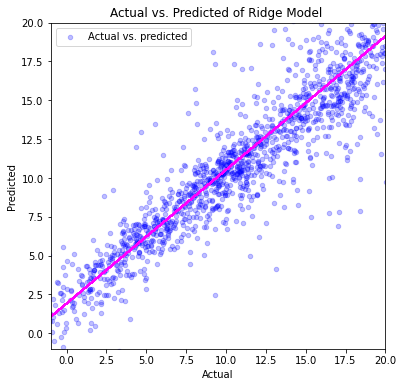

In [43]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
ridge_predictions2 = ridge_predictions.select("*").toPandas()

ax = ridge_predictions2.plot(kind='scatter', figsize = (6,6), x='temp', y='prediction', color='blue', alpha = 0.25, label='Actual vs. predicted');
fit = np.polyfit(ridge_predictions2['temp'], ridge_predictions2['prediction'], deg=1)
ax.set_title('Actual vs. Predicted of Ridge Model ')
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
ax.plot(ridge_predictions2['temp'], fit[0] * ridge_predictions2['temp'] + fit[1], color='magenta')
plt.axis([-1, 20, -1, 20])
plt.show(ax)

In [46]:
pip install --upgrade --no-deps statsmodels

     |████████████████████████████████| 8.7 MB 56.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [47]:
conda install statsmodels

Solving environment: done

## Package Plan ##

  environment location: /home/hadoop/miniconda

  added / updated specs:
    - statsmodels


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    patsy-0.5.1                |           py37_0         274 KB
    statsmodels-0.11.0         |   py37h7b6447c_0         7.8 MB
    ------------------------------------------------------------
                                           Total:         8.1 MB

The following NEW packages will be INSTALLED:

  patsy              pkgs/main/linux-64::patsy-0.5.1-py37_0
  statsmodels        pkgs/main/linux-64::statsmodels-0.11.0-py37h7b6447c_0



patsy-0.5.1          | 274 KB    | ##################################### | 100% 
statsmodels-0.11.0   | 7.8 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to r

Text(0, 0.5, 'Residuals')

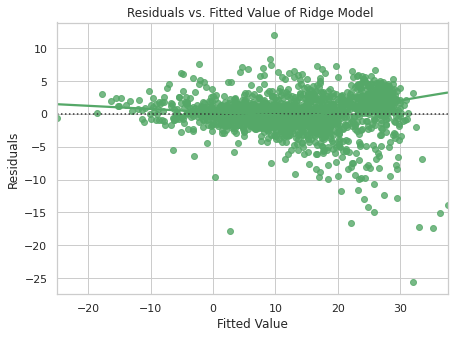

In [48]:
import seaborn as sns
import statsmodels
import matplotlib.pyplot as plt
f,ax =  plt.subplots(figsize = (7, 5))
sns.set(style="whitegrid")
sns.residplot(ridge_predictions2['temp'], ridge_predictions2['prediction'], lowess=True, color="g")

ax.set_title('Residuals vs. Fitted Value of Ridge Model ')
ax.set_xlabel("Fitted Value")
ax.set_ylabel("Residuals")

## Lasso Regression

In [50]:
Lasso= LinearRegression(featuresCol='features', labelCol='temp', regParam=0.5, elasticNetParam=1)
Lasso_model = Lasso.fit(train_df)

print("Coefficients: " + str(Lasso_model.coefficients))
print("Intercept: " + str(Lasso_model.intercept))

Coefficients: [0.0,-0.008140268516979183,0.8688355971298938,0.0,0.0,0.0,0.0006694838428656826,0.00014483911629636174,0.0]
Intercept: 4.445629951030618


In [51]:
[features[i] for i in np.nonzero(Lasso_model.coefficients)[0]]

['latitude', 'dew', 'elevation', 'cig']

In [52]:
lasso_predictions = Lasso_model.transform(test_df)

In [55]:
lasso_predictions.show(10)

+--------------------+-----------+-------------------+
|            features|       temp|         prediction|
+--------------------+-----------+-------------------+
|[0.01480263192206...| -1.6118422|-0.1759913027013944|
|[0.02222222276031...|        3.3| -3.266042353928233|
|[0.03113413602113...|-0.24210526|    4.8862792637767|
|[0.05067010968923...|  11.252631| 10.444767040857041|
|[0.10219086706638...|   8.967435|   8.78283342337706|
|[0.11067678779363...|  17.566782| 15.531718193570986|
|[0.23797114193439...|   8.308922|  9.812118917410146|
|[0.26496475934982...|   28.14353|  29.31237935220993|
|[0.31152597069740...|  11.172728| 12.625918431335734|
|[0.41241344809532...|   9.521662| 11.424999603954884|
+--------------------+-----------+-------------------+
only showing top 10 rows



In [56]:
lasso_predictions_rdd=lasso_predictions['temp', 'prediction'].rdd
lasso_metrics = RegressionMetrics(lasso_predictions_rdd)
# Squared Error
print("MSE = %s" % lasso_metrics.meanSquaredError)
print("RMSE = %s" % lasso_metrics.rootMeanSquaredError)
# R-squared
print("R-squared = %s" % lasso_metrics.r2)
# Mean absolute error
print("MAE = %s" % lasso_metrics.meanAbsoluteError)
# Explained variance
print("Explained variance = %s" % lasso_metrics.explainedVariance)

MSE = 9.896444330633516
RMSE = 3.145861460813797
R-squared = 0.8667149278693098
MAE = 2.0733769370013295
Explained variance = 94.30832029978136


/usr/lib/spark/python/pyspark/sql/dataframe.py:2103: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


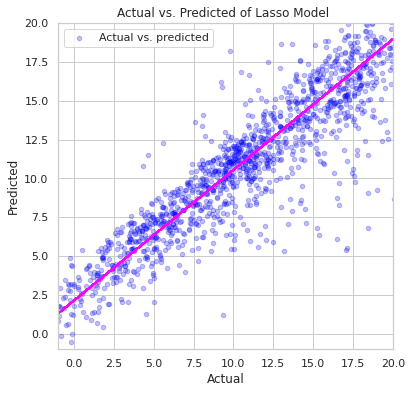

In [57]:
lasso_predictions2 = lasso_predictions.select("*").toPandas()

ax = lasso_predictions2.plot(kind='scatter', figsize = (6,6), x='temp', y='prediction', color='blue', alpha = 0.25, label='Actual vs. predicted');
fit = np.polyfit(lasso_predictions2['temp'], lasso_predictions2['prediction'], deg=1)
ax.set_title('Actual vs. Predicted of Lasso Model ')
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
ax.plot(lasso_predictions2['temp'], fit[0] * lasso_predictions2['temp'] + fit[1], color='magenta')
plt.axis([-1, 20, -1, 20])
plt.show(ax)

Text(0, 0.5, 'Residuals')

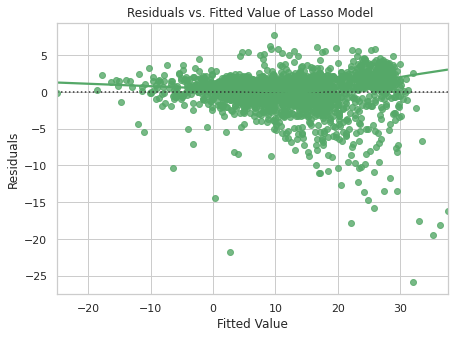

In [58]:
f,ax =  plt.subplots(figsize = (7, 5))
sns.set(style="whitegrid")
sns.residplot(lasso_predictions2['temp'], lasso_predictions2['prediction'], lowess=True, color="g")

ax.set_title('Residuals vs. Fitted Value of Lasso Model ')
ax.set_xlabel("Fitted Value")
ax.set_ylabel("Residuals")

## Decision Tree

In [114]:
from pyspark.ml.regression import DecisionTreeRegressor

In [138]:
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'temp')
dt_model = dt.fit(train_df)

In [139]:
dt_predictions = dt_model.transform(test_df)

In [140]:
evaluator_dt = RegressionEvaluator(labelCol='temp')

In [141]:
evaluator_dt.evaluate(dt_predictions, {evaluator_dt.metricName: "r2"})

0.9048872513702393

In [142]:
dt_evaluator = RegressionEvaluator(
    labelCol="temp", predictionCol="prediction", metricName="rmse")
rmse3 = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse3)

Root Mean Squared Error (RMSE) on test data = 2.99601


In [143]:
dt_model.featureImportances

SparseVector(9, {0: 0.0132, 1: 0.0398, 2: 0.9211, 6: 0.0077, 7: 0.0158, 8: 0.0024})

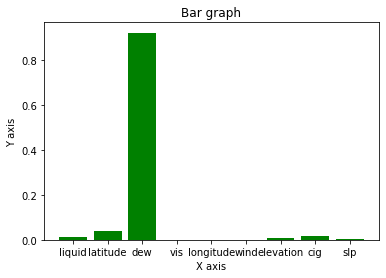

In [159]:
from matplotlib import pyplot as plt 
x =  features
y =  dt_model.featureImportances 
plt.bar(x, y, align =  'center',color='g') 
plt.title('Bar graph') 
plt.ylabel('Y axis') 
plt.xlabel('X axis') 
plt.show()

## Gradient-boosted tree regression

In [113]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'temp', maxIter=10)
gbt_model = gbt.fit(train_df)

In [115]:
gbt_predictions = gbt_model.transform(test_df)

In [116]:
evaluator_gbt = RegressionEvaluator(labelCol='temp')

In [119]:
evaluator_gbt.evaluate(gbt_predictions, {evaluator_gbt.metricName: "r2"})

0.9272543989837837

In [118]:
gbt_evaluator = RegressionEvaluator(
    labelCol="temp", predictionCol="prediction", metricName="rmse")
rmse4 = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse4)

Root Mean Squared Error (RMSE) on test data = 2.62016


In [73]:
sc.stop()